In [2]:
# collect real time cpi & Inflation Data

import pandas as pd
import requests


url = "http://api.worldbank.org/v2/country/IN/indicator/FP.CPI.TOTL?format=json"

response = requests.get(url)
data = response.json()


cpi_data = [
    {"Year": entry["date"], "CPI": entry["value"]}
    for entry in data[1] if entry["value"] is not None
]

df_cpi = pd.DataFrame(cpi_data)
df_cpi.sort_values(by="Year", ascending=True, inplace=True)

print(df_cpi.head())


    Year       CPI
49  1974  7.586970
48  1975  8.023102
47  1976  7.410622
46  1977  8.026258
45  1978  8.228764


In [3]:
# Preprocess CPI & Inflation Data

url = "http://api.worldbank.org/v2/country/IN/indicator/FP.CPI.TOTL.ZG?format=json"
response = requests.get(url)
data = response.json()


inflation_data = [
    {"Year": entry["date"], "Inflation": entry["value"]}
    for entry in data[1] if entry["value"] is not None
]

df_inflation = pd.DataFrame(inflation_data)
df_inflation.sort_values(by="Year", ascending=True, inplace=True)

print(df_inflation.head())


    Year  Inflation
49  1974  28.598734
48  1975   5.748430
47  1976  -7.633948
46  1977   8.307470
45  1978   2.523049


In [4]:
# Merge CPI & Inflation Data
# Merge CPI & Inflation Data
df = pd.merge(df_cpi, df_inflation, on="Year")
df["Year"] = pd.to_datetime(df["Year"]).dt.year

print(df.head())
print(df)
df.to_csv('cpi_data.csv', index=False)

   Year       CPI  Inflation
0  1974  7.586970  28.598734
1  1975  8.023102   5.748430
2  1976  7.410622  -7.633948
3  1977  8.026258   8.307470
4  1978  8.228764   2.523049
    Year         CPI  Inflation
0   1974    7.586970  28.598734
1   1975    8.023102   5.748430
2   1976    7.410622  -7.633948
3   1977    8.026258   8.307470
4   1978    8.228764   2.523049
5   1979    8.745175   6.275683
6   1980    9.737409  11.346073
7   1981   11.014232  13.112547
8   1982   11.883336   7.890743
9   1983   13.293660  11.868081
10  1984   14.399548   8.318907
11  1985   15.199648   5.556424
12  1986   16.526534   8.729721
13  1987   17.981055   8.801126
14  1988   19.668303   9.383472
15  1989   21.059694   7.074280
16  1990   22.949008   8.971233
17  1991   26.132091  13.870246
18  1992   29.212495  11.787817
19  1993   31.060737   6.326890
20  1994   34.243821  10.247936
21  1995   37.745213  10.224886
22  1996   41.133658   8.977152
23  1997   44.080577   7.164252
24  1998   49.912808  13.2

In [ ]:
# Train-Test Split for Forecasting

from sklearn.model_selection import train_test_split

X = df[["Year"]]
y_cpi = df["CPI"]
y_inflation = df["Inflation"]

X_train, X_test, y_train_cpi, y_test_cpi = train_test_split(X, y_cpi, test_size=0.2, random_state=42)
X_train, X_test, y_train_inflation, y_test_inflation = train_test_split(X, y_inflation, test_size=0.2, random_state=42)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


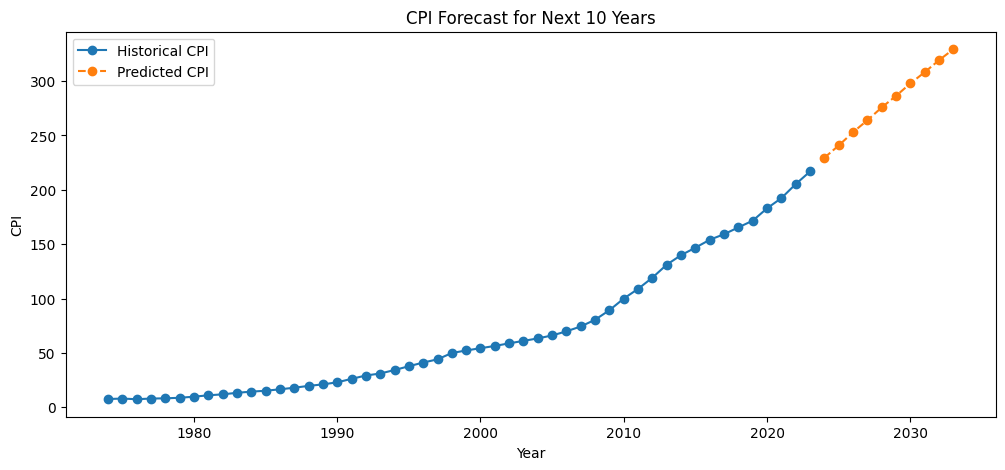

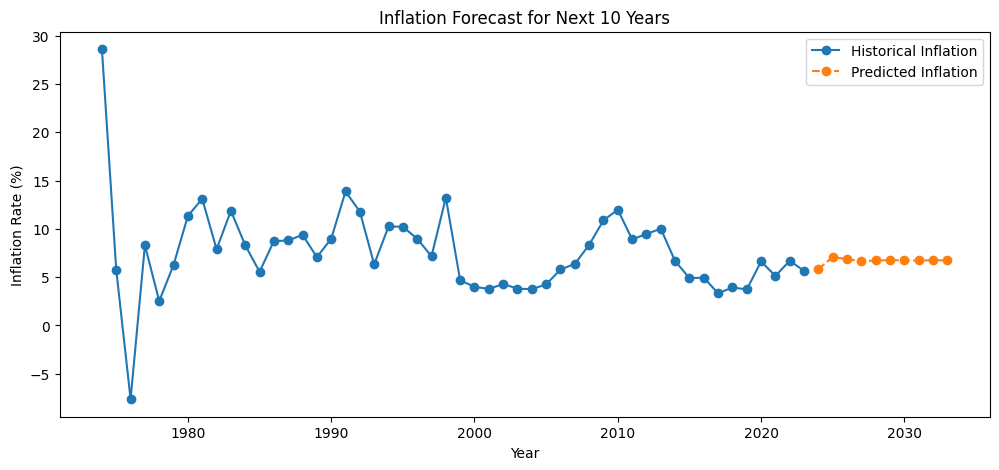

In [ ]:
# ARIMA → A time series forecasting model that captures patterns in data using AutoRegression (AR), Differencing (I), and Moving Average (MA).
# CPI & Inflation Prediction using ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


model_cpi = ARIMA(y_cpi, order=(2, 1, 2))  # (p, d, q)
model_cpi_fit = model_cpi.fit()


forecast_cpi = model_cpi_fit.forecast(steps=10)


model_inflation = ARIMA(y_inflation, order=(2, 1, 2))
model_inflation_fit = model_inflation.fit()

forecast_inflation = model_inflation_fit.forecast(steps=10)


future_years = range(df["Year"].max() + 1, df["Year"].max() + 11)


plt.figure(figsize=(12, 5))
plt.plot(df["Year"], df["CPI"], label="Historical CPI", marker="o")
plt.plot(future_years, forecast_cpi, label="Predicted CPI", linestyle="dashed", marker="o")
plt.xlabel("Year")
plt.ylabel("CPI")
plt.legend()
plt.title("CPI Forecast for Next 10 Years")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(df["Year"], df["Inflation"], label="Historical Inflation", marker="o")
plt.plot(future_years, forecast_inflation, label="Predicted Inflation", linestyle="dashed", marker="o")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.title("Inflation Forecast for Next 10 Years")
plt.show()


In [ ]:
# Deploy the Model using Flask API
from flask import Flask, request, jsonify
import numpy as np

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    year = int(data["year"])

    # Predict CPI & Inflation for Given Year
    pred_cpi = model_cpi_fit.forecast(steps=(year - df["Year"].max()))
    pred_inflation = model_inflation_fit.forecast(steps=(year - df["Year"].max()))

    return jsonify({
        "Predicted CPI": pred_cpi[-1],
        "Predicted Inflation": pred_inflation[-1]
    })

if __name__ == '__main__':
    app.run(debug=True)
